In [40]:
using Utils, Plots, LinearAlgebra
using DifferentialEquations
include("./Rocket_Acceleration.jl")
include("./Quaternions.jl") 

to_matrix (generic function with 1 method)

In [41]:
module scp_new_problem
include("./6dof fixed t_burn.jl")
end # module

using .scp_new_problem

In [42]:
solution = scp_new_problem.solve(:ptr); # Remember J is augmented cost function

k  | status   | vd    | vs    | vbc   | J         | ΔJ %      | Δx    | Δu    | Δp    | δ     | dyn | ηx    | ηu    | ηp   
---+----------+-------+-------+-------+-----------+-----------+-------+-------+-------+-------+-----+-------+-------+------
1  | OPTIMAL  | 1e-01 | 0e+00 | 3e-10 | 2.55e+01  |           | 8e-02 | 8e-03 | 2e-01 | 2e-01 | T   | 0.09  | 0.01  | 0.16 


2  | ALMOST_O | 3e-03 | 0e+00 | 5e-09 | 6.00e+00  | 76.43     | 1e-02 | 2e-03 | 3e-02 | 4e-02 | T   | 0.02  | 0.01  | 0.03 


3  | ALMOST_O | 6e-04 | 0e+00 | 4e-08 | 5.61e+00  | 6.50      | 3e-03 | 1e-03 | 9e-04 | 4e-03 | T   | 0.01  | 0.00  | 0.00 
4  | ALMOST_O | 2e-05 | 0e+00 | 3e-07 | 5.62e+00  | -0.07     | 2e-03 | 1e-03 | 9e-05 | 2e-03 | T   | 0.44  | 0.16  | 0.00 


Coast time (s): 1.3638690805753184
Impact Velocity Magnitude (m/s): 2.3698237654129217


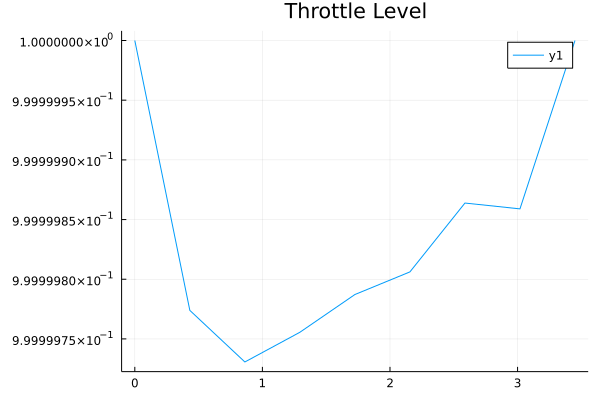

In [43]:
scp_new_problem.print(solution)
scp_new_problem.plot(solution)
# scp_new_problem.save(solution)

# t = solution.td * 3.45
# Plots.plot(t, norm.(eachcol(solution.ud[1:3, :])), title = "Thrust (N)" )

In [44]:
N = size(solution.ud)[2]
t = solution.td * 3.45
dt = t[2]
u_normalised = deepcopy(solution.ud)

for k = 1:N
    if norm(u_normalised[1:3, k]) <= 1e-4
        u_normalised[1:3, k] = [0; 0; 1]
    end
end

u_normalised[1:3, :] =  u_normalised[1:3, :] ./ norm.(eachcol(u_normalised[1:3, :]))'

display(solution.ud)
display(u_normalised)

4×9 Matrix{Float64}:
 -5.04435e-9   0.414659    -0.567444    …   0.195597      1.94459e-8
 -1.54668e-8  -0.311049     0.425458       -0.147076      8.74742e-9
  1.72577e-8  22.8204      15.0247         12.8323        5.52988e-8
  8.55526e-5  -8.22653e-5   7.17954e-5      0.000128031  -6.26181e-5

4×9 Matrix{Float64}:
 0.0          0.0181659   -0.0377253   …   0.0152398     0.0
 0.0         -0.0136268    0.0282857      -0.0114593     0.0
 1.0          0.999742     0.998888        0.999818      1.0
 8.55526e-5  -8.22653e-5   7.17954e-5      0.000128031  -6.26181e-5

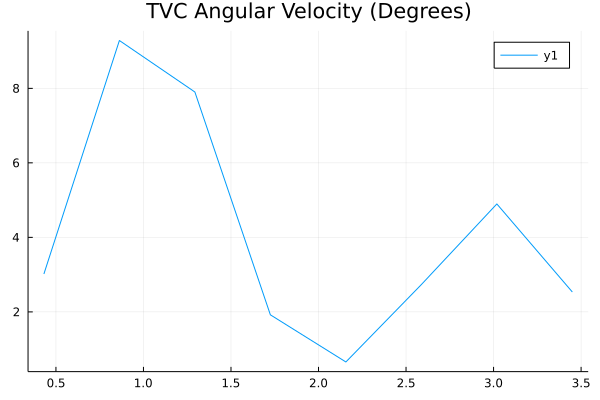

In [45]:
tvc_dot_max = zeros(N - 1)

for k = 1:N-1
    tvc_dot_max[k] = atand(norm(u_normalised[1:3, k] × u_normalised[1:3, k + 1]), u_normalised[1:3, k] ⋅ u_normalised[1:3, k + 1]) / dt # https://discourse.julialang.org/t/how-to-find-angle-between-two-vectors/68149/3
    # acosd(u_normalised[1:3, k] ⋅ u_normalised[1:3, k + 1] ) / dt
end
Plots.plot(t[2:N], tvc_dot_max, title = "TVC Angular Velocity (Degrees)")

In [46]:
# t_burn = 3.45
# g = [0; 0; -9.80655]

# # Continuous version of u
# function uc(u, u_normalised, dt, t, slerpBool, realAcceleration) 
#     if t < 0 || t >= t_burn 
#         return [0; 0; 0]
#     else 
#         tmp = Int(t ÷ dt) #floor(Int, t / dt)
#         frac = (t % dt) / dt

#         if slerpBool
#             u_normalised = slerp(u_normalised[1:3, tmp + 1], u_normalised[1:3, tmp + 2], frac)
#         else
#             tmp = u[1:3, tmp + 1] + frac * (u[1:3, tmp + 2] - u[1:3, tmp + 1])
#             u_normalised = tmp / norm(tmp)
#         end

#         if realAcceleration
#             Thrust = u_normalised * Acceleration(t)
#         else
#             normu = norm(u[1:3, tmp + 1]) + frac * (norm(u[1:3, tmp + 2]) - norm(u[1:3, tmp + 1]))
#             Thrust = u_normalised * normu
#         end

#         return [Thrust; u[4, tmp + 1] + frac * (u[4, tmp + 2] - u[4, tmp + 1])]
#     end
# end

# function f!(dx, x, p, t)
#     r = x[1:3]
#     v = x[4:6]
#     quat = x[7:10]
#     w = x[11:13]

#     #Control = uc(solution.ud, u_normalised, dt, t, false, false) 
#     Control = sample(solution.uc, t / 3.45)

#     Id = Diagonal([0.2, 0.2, 0.04])
#     invId = Diagonal([5.0, 5.0, 25.0])

#     dx[1:3] = v
#     dx[4:6] = g + rotate(quat, Control[1:3])
#     dx[7:10] = 1/2 * quatL(quat) * [0; w]
#     dx[11:13] = invId * ( cross([0; 0; -0.5], Control[1:3]) + [0; 0; Control[4]] - cross(w, Id * w))
# end

# prob = ODEProblem(f!, solution.xd[:, 1], (0.0, t_burn))
# sol = DifferentialEquations.solve(prob, reltol=1e-12, abstol=1e-12, maxiters=10^20)

# xc = sol(t).u
# xmatrix = transpose(reduce(hcat, xc))
# # plot(xmatrix[:, 1], xmatrix[:, 2], xmatrix[:, 3])
# # # plot(sol)

In [47]:
# above is same as solution.xc if false, false?

xc = [sample(solution.xc, t) for t in solution.td];
xmatrix = transpose(reduce(hcat, xc));
show(stdout, "text/plain", xmatrix)

9×13 transpose(::Matrix{Float64}) with eltype Float64:
 25.4555   -8.09161  20.8792      4.0       -3.0       -13.3749    0.999999  -2.34697e-9   9.36073e-10  -1.53757e-11  -3.6047e-9    1.16634e-9   1.84404e-11
 27.1888   -9.39159  14.907       4.02609   -3.01957   -12.6821    0.999798  -0.0120551   -0.0160708     3.44054e-5   -0.167676    -0.223521     1.76806e-5
 28.8018  -10.6014   10.3975      3.26868   -2.45148    -8.82202   0.995678  -0.0557275   -0.0742875     1.97543e-6   -0.105938    -0.141106    -3.86235e-5
 29.9746  -11.4809    7.01036     2.25434   -1.69038    -6.95164   0.996579  -0.0496044   -0.066103      1.56985e-6    0.0682935    0.0909604   -0.000294546
 30.7963  -12.0969    4.37394     1.56408   -1.17252    -5.27932   0.997532  -0.0420955   -0.0561859    -0.000257105   0.0228772    0.0301651   -0.0024137
 31.3338  -12.4999    2.44593     0.949146  -0.712015   -3.68298   0.998124  -0.0366703   -0.049015     -0.000640402   0.0200318    0.0271152    0.000940372
 31.623

   -2.35953   1.0        2.45276e-6   3.22994e-6    7.49727e-5    1.83103e-6   2.37519e-6  -2.70104e-7

In [48]:
println(norm(xmatrix - solution.xd', Inf))
println(norm(xmatrix - solution.xd'))

v_N = [0;0;0]
println("Cost: $(norm(xmatrix[end, 4:6] - v_N))")

0.001984077859443986
0.0040596099428578305
Cost: 2.369383020172012


In [49]:
# xmatrix - solution.xd'
show(stdout, "text/plain", xmatrix - solution.xd')

9×13 Matrix{Float64}:
  0.0           0.0           0.0           0.0           0.0           0.0           0.0          0.0          0.0          0.0           0.0          0.0          0.0
 -3.22171e-6    2.41811e-6    0.000147578  -6.67562e-5    5.0085e-5     0.000344641   2.05162e-7  -4.39381e-6  -5.86662e-6  -1.14015e-8    2.50514e-6   3.37488e-6  -4.00131e-8
 -4.32993e-5    3.24267e-5   -2.11173e-5    6.13471e-5   -4.63229e-5   -0.000776669  -9.97551e-6   1.43946e-5   1.91961e-5  -5.95459e-10   5.21235e-5   6.95701e-5   9.48774e-8
  3.36587e-5   -2.54639e-5   -0.000295949   0.000245549  -0.000184538  -0.000696528   2.08291e-6   5.11544e-7   6.74419e-7  -2.02443e-7   -4.3567e-5   -5.81167e-5  -2.46056e-7
  0.000127387  -9.58552e-5   -0.000578943   0.000244656  -0.000183543  -0.000669259   2.1072e-6    2.95659e-6   3.94099e-6  -3.13101e-7    4.46169e-6   6.07923e-6   4.37041e-7
  0.000245803  -0.000184613  -0.000869298   0.000279216  -0.000208911  -0.00065655    5.58881e-8   2.3155

In [50]:
norm.(eachcol(solution.xd[7:10, :]))

9-element Vector{Float64}:
 0.9999991374718902
 0.9999994361397977
 1.000011997681809
 0.9999979140891943
 0.9999982344562406
 1.0000001760457702
 1.0000039299749677
 0.9999980369649275
 0.9999978236925295